In [1]:
import time
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from itertools import product
import gc
import optuna
import shap
from sklearn.ensemble import RandomForestRegressor

In [2]:
def read_data(path: str, files: list):
    dataframes = []
    for file in files:
        dataframes.append(pd.read_csv(path + file))
    return dataframes


path = '../input/competitive-data-science-predict-future-sales/'
files = ['sales_train.csv', 'items.csv', 'shops.csv', 'item_categories.csv', 'test.csv']
sales_train, items, shops, item_categories, test = read_data(path, files)
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [3]:
def remove_outliers(df: pd.DataFrame, max_price: int, max_cnt: int):  
    df = df[df['item_price'] > 0]
    df = df[df['item_price'] < max_price]
    df = df[df['item_cnt_day'] > 0]
    df = df[df['item_cnt_day'] < max_cnt]
    return df


sales_train = remove_outliers(sales_train, 50000, 1000)

In [4]:
def remove_shop_duplicates(df_train: pd.DataFrame, df_test: pd.DataFrame, shop_dups: dict):
    for shop1, shop2 in shop_dups.items():
        df_train.loc[df_train['shop_id'] == shop1, 'shop_id'] = shop2
        df_test.loc[df_test['shop_id'] == shop1, 'shop_id'] = shop2
        

shop_dups = {0: 57, 1: 58, 10: 11, 39: 40}
remove_shop_duplicates(sales_train, test, shop_dups)

In [5]:
def create_city_feature(shops_df: pd.DataFrame, corrections: dict):
    shops_df['city'] = shops_df['shop_name'].str.extract(r'(\w+\.*\w*)')
    for city1, city2 in corrections.items():        
        shops_df.loc[shops_df.city == city1, 'city'] = city2
    shops_df['city'] = LabelEncoder().fit_transform(shops['city'])
    
    
corrections = {'Выездная': 'Выездная торговля', 'РостовНаДону': 'Ростов-На-Дону',
               'Сергиев': 'Сергиев Посад', 'Цифровой': 'Интернет'}
create_city_feature(shops, corrections)
shops.head()

,shop_name,shop_id,city
0,"!Якутск Орджоникидзе, 56 фран",0,28
1,"!Якутск ТЦ ""Центральный"" фран",1,28
2,"Адыгея ТЦ ""Мега""",2,0
3,"Балашиха ТРК ""Октябрь-Киномир""",3,1
4,"Волжский ТЦ ""Волга Молл""",4,2


In [6]:
def find_shop_item_pairs(data: pd.DataFrame):
    pairs = []
    shops = data['shop_id'].unique()
    for shop in shops:
        pairs.append((shop, data[data['shop_id'] == shop]['item_id'].unique()))
    return pairs


shop_item_pairs = find_shop_item_pairs(sales_train)

In [7]:
def create_train(month_range: list, shops_items: list):
    train = []
    for month in month_range:
        for shop, items in shops_items:
            train.append(np.array(list(product([month], [shop], items))))
    train = pd.DataFrame(np.vstack(train), columns=['date_block_num', 'shop_id', 'item_id'])
    return train


train = create_train(sales_train.date_block_num.unique(), shop_item_pairs)
train

,date_block_num,shop_id,item_id
0,0,59,22154
1,0,59,22151
2,0,59,5603
3,0,59,5587
4,0,59,5613
...,...,...,...
14218727,33,36,20231
14218728,33,36,20334
14218729,33,36,20339
14218730,33,36,20352


In [8]:
def aggregate_on_month_level(train_df: pd.DataFrame, sales_train_df: pd.DataFrame, test_df: pd.DataFrame): 
    group = sales_train_df.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_day': 'sum', 'item_price': 'mean'}).reset_index()
    group = group.rename(columns={'item_cnt_day': 'item_cnt_month', 'item_price': 'item_price_mean'})
    all_data = train_df.merge(group, on=['date_block_num', 'shop_id', 'item_id'], how='left')
    
    test = test_df.merge(group[group['date_block_num'] == 33], on=['shop_id', 'item_id'], how='left')
    test = test.fillna(0)    
    test['date_block_num'] = 34

    all_data = pd.concat([all_data, test.drop(columns='ID')], ignore_index=True, keys=['date_block_num', 'shop_id', 'item_id'])
    all_data = all_data.fillna(0)
    all_data['item_cnt_month'] = all_data['item_cnt_month'].clip(0,20)
    return all_data


all_data = aggregate_on_month_level(train, sales_train, test)

In [9]:
def add_lag_features(lag_months: list, month_range: range):
    lags = pd.DataFrame()
    for month in month_range:
        cur_month = all_data[all_data.date_block_num == month]
        for lag in lag_months:
            cur_lag = all_data[all_data.date_block_num == month - lag]
            cur_lag = cur_lag.rename({'item_cnt_month': 'item_cnt_last_{}'.format(lag),
                                      'item_price_mean': 'item_price_last_{}'.format(lag)}, axis=1)

            cur_item_lag = all_data[all_data.date_block_num == month - lag]
            cur_item_lag = cur_item_lag.groupby(['item_id'], as_index=False).agg({'item_cnt_month': 'sum', 'item_price_mean': 'mean'})
            cur_item_lag = cur_item_lag.rename({'item_cnt_month': 'item_cnt_last_{}_item'.format(lag),
                                                'item_price_mean': 'item_price_last_{}_item'.format(lag)},
                                                axis=1)

            cur_month = cur_month.merge(cur_lag.drop(columns='date_block_num'), how='left',
                                        on=['shop_id', 'item_id'])
            cur_month = cur_month.merge(cur_item_lag,
                                        how='left', on=['item_id'])
        lags = pd.concat([lags, cur_month], ignore_index=True)
        
    lags = lags.fillna(0)
    return lags

lag_months = [1, 2, 3, 12]
month_range = range(12, all_data.date_block_num.nunique())
all_data = add_lag_features(lag_months, month_range)

In [10]:
items['first_sale_date'] = sales_train.groupby('item_id').agg({'date_block_num': 'min'})['date_block_num']
items['first_sale_date'] = items['first_sale_date'].fillna(34)

all_data = all_data.merge(shops[['shop_id', 'city']], on='shop_id', how='left')
all_data = all_data.merge(items[['item_id', 'item_category_id', 'first_sale_date']], on='item_id', how='left')
all_data = all_data.merge(item_categories.drop('item_category_name', axis=1), on='item_category_id', how='left')

all_data['new_item'] = all_data['first_sale_date'] == all_data['date_block_num']
all_data = all_data.drop('first_sale_date', axis=1)

all_data.head()

,date_block_num,shop_id,item_id,item_cnt_month,item_price_mean,item_cnt_last_1,item_price_last_1,item_cnt_last_1_item,item_price_last_1_item,item_cnt_last_2,...,item_price_last_3,item_cnt_last_3_item,item_price_last_3_item,item_cnt_last_12,item_price_last_12,item_cnt_last_12_item,item_price_last_12_item,city,item_category_id,new_item
0,12,59,22154,0.0,0.0,0.0,0.0,1.0,41.625000,0.0,...,0.0,3.0,124.875000,1.0,999.0,18.0,582.750000,29,37,False
1,12,59,22151,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,2.0,399.0,239.0,357.833571,29,40,False
2,12,59,5603,0.0,0.0,0.0,0.0,4.0,57.384615,0.0,...,0.0,3.0,45.923077,1.0,699.0,6.0,145.011538,29,5,False
3,12,59,5587,0.0,0.0,0.0,0.0,21.0,69.574468,0.0,...,0.0,54.0,94.978723,2.0,199.0,67.0,118.605319,29,5,False
4,12,59,5613,0.0,0.0,1.0,6090.0,49.0,3107.142857,0.0,...,0.0,20.0,2052.333333,1.0,5571.0,15.0,1503.285714,29,2,False


In [11]:
del shops, items, item_categories, train
gc.collect()

64

In [12]:
def downcast(df, verbose=True):
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        dtype_name = df[col].dtype.name
        if dtype_name == 'object':
            pass
        elif dtype_name == 'bool':
            df[col] = df[col].astype('int8')
        elif dtype_name.startswith('int') or (df[col].round() == df[col]).all():
            df[col] = pd.to_numeric(df[col], downcast='integer')
        else:
            df[col] = pd.to_numeric(df[col], downcast='float')
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print('{:.1f}% compressed'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

all_data = downcast(all_data)
gc.collect()

66.8% compressed


13

In [13]:
class TimeSeriesCycle:
    def __init__(self,
                 data: pd.DataFrame,
                 models_with_params: dict,
                 metric: object,
                 start_border: int,
                 train_border: int,
                 valid_border: int,
                 test_border: int,
                 cv_step: int,
                 optuna_trials: int
                ):
        self.data = data
        self.models_with_params = models_with_params
        self.metric = metric
        self.start_border = start_border
        self.train_border = train_border
        self.valid_border = valid_border
        self.test_border = test_border    
        self.cv_step = cv_step
        self.optuna_trials = optuna_trials
        self.best_estimators = []
        self.final_estimator = None
        
   
    def evaluate_model(self, model, params):
        def objective(trial):
            model.set_params(**params(trial))
            scores = []
            for i in range(self.start_border + self.cv_step, self.train_border + 1, self.cv_step):
                X_train = self.data[self.data['date_block_num'] < i].drop(columns=['item_cnt_month'])
                y_train = self.data[self.data['date_block_num'] < i]['item_cnt_month']
                X_valid = self.data[self.data['date_block_num'] == i].drop(columns=['item_cnt_month'])
                y_valid = self.data[self.data['date_block_num'] == i]['item_cnt_month']

                model.fit(X_train, y_train)
                preds = model.predict(X_valid).clip(0, 20)
                scores.append(self.metric(y_valid, preds))
            return np.mean(scores)
        
        
        start = time.time()
        study_name = 'study'
        study = optuna.create_study(study_name=study_name, direction='minimize')
        study.optimize(objective, n_trials=self.optuna_trials, show_progress_bar=True, gc_after_trial=True)
        end = time.time()
        
        print('Best score: {}'.format(study.best_value))
        print('Best params: {}'.format(study.best_params))
        print('Taken time: {}'.format(int(end - start)))
        
        self.best_estimators.append((model, study.best_params))
    
    
    def compare_models(self):
        for model, params in self.models_with_params.items():
            print('Hyperparameters tuning for ' + str(type(model).__name__))
            self.evaluate_model(model, params)
            
        X_train = self.data[self.data['date_block_num'] <= self.train_border].drop(columns=['item_cnt_month'])
        y_train = self.data[self.data['date_block_num'] <= self.train_border]['item_cnt_month']
        X_valid = self.data[self.data['date_block_num'] == self.valid_border].drop(columns=['item_cnt_month'])
        y_valid = self.data[self.data['date_block_num'] == self.valid_border]['item_cnt_month']
        
        scores = []
        for model, params in self.best_estimators:
            model.set_params(**params)
            model.fit(X_train, y_train)
            preds = model.predict(X_valid).clip(0, 20)
            score = self.metric(preds, y_valid)
            print('Validation set score for {} = '.format(type(model).__name__) + str(score))
            scores.append(score)
            
        self.final_estimator = self.best_estimators[np.argmin(scores)]
    
    def get_predictions(self):
        start = time.time()
        
        model, params = self.final_estimator
        model.set_params(**params)
        print('Final model: ' + str(model))
        X = self.data[self.data['date_block_num'] <= self.valid_border].drop(columns=['item_cnt_month'])
        y = self.data[self.data['date_block_num'] <= self.valid_border]['item_cnt_month']
        print('Fitting...')
        model.fit(X, y)
        X_test = self.data[self.data['date_block_num'] == self.test_border].drop(columns=['item_cnt_month'])
        y_test = model.predict(X_test).clip(0, 20)
        
        end = time.time()
        print('Took ' + str(int(end - start)) + ' seconds to get final predictions')
        self.final_estimator = model
        return y_test
    
    def explain_model(self, model):
        explainer = shap.Explainer(model)
        shap_values = explainer(
            self.data[self.data['date_block_num'] == self.test_border].drop(columns=['item_cnt_month'])
        )
        shap.plots.waterfall(shap_values[0])

In [14]:
def rmse_metric(y_valid, y_pred):
    return mean_squared_error(y_valid, y_pred, squared=False)


xgb_model = XGBRegressor()
def xgb_params(trial):
    params = {
              'n_estimators': trial.suggest_int('n_estimators', 1, 150),
              'max_depth': trial.suggest_int('max_depth', 3, 12),
              'reg_alpha': trial.suggest_uniform('reg_alpha', 0, 4),
              'reg_lambda': trial.suggest_uniform('reg_lambda', 0, 2),
              'min_child_weight': trial.suggest_int('min_child_weight', 0, 5),
              'gamma': trial.suggest_uniform('gamma', 0, 4),
              'learning_rate': trial.suggest_loguniform('learning_rate', 0.05, 0.5),
              'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 0.9),
              'subsample': trial.suggest_uniform('subsample', 0.4, 0.9),
              'nthread': -1
              }
    return params

rf_model = RandomForestRegressor()
def rf_params(trial):
    params = {
             'bootstrap': trial.suggest_categorical('bootstrap', ['True', 'False']),
             'max_depth': trial.suggest_int('max_depth', 1, 20),
             'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2']),
             'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 8),
             'n_estimators': trial.suggest_int('n_estimators', 1, 300),
             'n_jobs': -1
             }
    return params

tsc = TimeSeriesCycle(data=all_data,
                      models_with_params={rf_model: rf_params,
                                          xgb_model: xgb_params
                                          },
                      metric=rmse_metric,
                      start_border=12,
                      train_border=32,
                      valid_border=33,
                      test_border=34,
                      cv_step=5,
                      optuna_trials=20
                     )

In [20]:
tsc.compare_models()

[I 2022-10-15 13:33:37,027] A new study created in memory with name: study


Hyperparameters tuning for RandomForestRegressor


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2022-10-15 13:53:01,037] Trial 0 finished with value: 0.5996945427398732 and parameters: {'bootstrap': 'True', 'max_depth': 16, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'n_estimators': 279}. Best is trial 0 with value: 0.5996945427398732.
[I 2022-10-15 13:58:33,998] Trial 1 finished with value: 0.6987417913533489 and parameters: {'bootstrap': 'True', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 2, 'n_estimators': 126}. Best is trial 0 with value: 0.5996945427398732.
[I 2022-10-15 14:09:56,844] Trial 2 finished with value: 0.638789899934623 and parameters: {'bootstrap': 'True', 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 1, 'n_estimators': 137}. Best is trial 0 with value: 0.5996945427398732.
[I 2022-10-15 14:11:41,218] Trial 3 finished with value: 0.6104645182145554 and parameters: {'bootstrap': 'False', 'max_depth': 14, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 24}. Best is trial 0 with value: 0.5996945427398732.
[I 2022-10-

[I 2022-10-15 17:29:01,443] A new study created in memory with name: study


Best score: 0.5925412806286984
Best params: {'bootstrap': 'True', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 4, 'n_estimators': 76}
Taken time: 14124
Hyperparameters tuning for XGBRegressor


Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


  0%|          | 0/20 [00:00<?, ?it/s]

suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instea

[I 2022-10-15 17:39:58,303] Trial 0 finished with value: 0.6756086349487305 and parameters: {'n_estimators': 39, 'max_depth': 11, 'reg_alpha': 3.4884166444054254, 'reg_lambda': 0.790936989699504, 'min_child_weight': 4, 'gamma': 1.7234368578444537, 'learning_rate': 0.054256679307264404, 'colsample_bytree': 0.43331818037942227, 'subsample': 0.6061327691417693}. Best is trial 0 with value: 0.6756086349487305.


suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instea

[I 2022-10-15 18:07:51,488] Trial 1 finished with value: 0.5953853130340576 and parameters: {'n_estimators': 61, 'max_depth': 12, 'reg_alpha': 3.2117759502916137, 'reg_lambda': 1.079858509412473, 'min_child_weight': 2, 'gamma': 0.38432744547761777, 'learning_rate': 0.06799710369152133, 'colsample_bytree': 0.6847409394899387, 'subsample': 0.7497448707288403}. Best is trial 1 with value: 0.5953853130340576.


suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instea

[I 2022-10-15 18:45:37,555] Trial 2 finished with value: 0.6125878691673279 and parameters: {'n_estimators': 137, 'max_depth': 10, 'reg_alpha': 1.9423692324404258, 'reg_lambda': 0.49322243165023694, 'min_child_weight': 0, 'gamma': 3.213739348189576, 'learning_rate': 0.23113581384269932, 'colsample_bytree': 0.49322701660590995, 'subsample': 0.7705955654258394}. Best is trial 1 with value: 0.5953853130340576.


suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instea

[I 2022-10-15 19:36:02,619] Trial 3 finished with value: 0.6658269762992859 and parameters: {'n_estimators': 110, 'max_depth': 12, 'reg_alpha': 0.16783847618452974, 'reg_lambda': 0.996068604840288, 'min_child_weight': 3, 'gamma': 0.7120231766013716, 'learning_rate': 0.4915507240423855, 'colsample_bytree': 0.7130465757307921, 'subsample': 0.6343200826321813}. Best is trial 1 with value: 0.5953853130340576.


suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instea

[I 2022-10-15 19:40:24,254] Trial 4 finished with value: 0.6261729598045349 and parameters: {'n_estimators': 61, 'max_depth': 3, 'reg_alpha': 0.24382562349663806, 'reg_lambda': 1.7302954156979777, 'min_child_weight': 2, 'gamma': 3.8329265320361956, 'learning_rate': 0.33061542365807695, 'colsample_bytree': 0.47547799349012465, 'subsample': 0.7813973899247189}. Best is trial 1 with value: 0.5953853130340576.


suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instea

[I 2022-10-15 19:54:33,790] Trial 5 finished with value: 0.6115846633911133 and parameters: {'n_estimators': 105, 'max_depth': 4, 'reg_alpha': 0.5275207857854123, 'reg_lambda': 0.7837754701362194, 'min_child_weight': 0, 'gamma': 0.8484083496014185, 'learning_rate': 0.13007897914965774, 'colsample_bytree': 0.7567393451501125, 'subsample': 0.6476224011169204}. Best is trial 1 with value: 0.5953853130340576.


suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instea

[I 2022-10-15 20:12:03,078] Trial 6 finished with value: 0.6184650659561157 and parameters: {'n_estimators': 145, 'max_depth': 4, 'reg_alpha': 1.1335354264058322, 'reg_lambda': 0.14970336939161677, 'min_child_weight': 1, 'gamma': 2.550933540829218, 'learning_rate': 0.061469315103736356, 'colsample_bytree': 0.7209150875453469, 'subsample': 0.5129332108759045}. Best is trial 1 with value: 0.5953853130340576.


suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instea

[I 2022-10-15 20:49:28,745] Trial 7 finished with value: 0.6044595241546631 and parameters: {'n_estimators': 122, 'max_depth': 12, 'reg_alpha': 0.0576534032501419, 'reg_lambda': 1.2768422957136776, 'min_child_weight': 2, 'gamma': 2.41979593179285, 'learning_rate': 0.07882537187765906, 'colsample_bytree': 0.40602579046731235, 'subsample': 0.4072476765010114}. Best is trial 1 with value: 0.5953853130340576.


suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instea

[I 2022-10-15 20:57:08,661] Trial 8 finished with value: 0.6267110109329224 and parameters: {'n_estimators': 71, 'max_depth': 4, 'reg_alpha': 3.1504331258891316, 'reg_lambda': 1.0217266453121925, 'min_child_weight': 3, 'gamma': 1.3589742073724476, 'learning_rate': 0.07014077601663371, 'colsample_bytree': 0.6837871893632645, 'subsample': 0.8595687932482545}. Best is trial 1 with value: 0.5953853130340576.


suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instea

[I 2022-10-15 21:34:59,083] Trial 9 finished with value: 0.614905595779419 and parameters: {'n_estimators': 144, 'max_depth': 10, 'reg_alpha': 0.8237338830945804, 'reg_lambda': 0.29682671819137063, 'min_child_weight': 4, 'gamma': 3.7325265671997414, 'learning_rate': 0.40018830994993326, 'colsample_bytree': 0.515539506992019, 'subsample': 0.8740716717828471}. Best is trial 1 with value: 0.5953853130340576.


suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instea

[I 2022-10-15 21:36:18,508] Trial 10 finished with value: 0.7664588093757629 and parameters: {'n_estimators': 5, 'max_depth': 7, 'reg_alpha': 2.747524212968416, 'reg_lambda': 1.999739116896183, 'min_child_weight': 5, 'gamma': 0.06700544050978507, 'learning_rate': 0.11822001860567852, 'colsample_bytree': 0.8926964015940188, 'subsample': 0.7430079814278033}. Best is trial 1 with value: 0.5953853130340576.


suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instea

[I 2022-10-15 21:59:44,114] Trial 11 finished with value: 0.5902111530303955 and parameters: {'n_estimators': 100, 'max_depth': 8, 'reg_alpha': 3.9544361496240295, 'reg_lambda': 1.4564879097654209, 'min_child_weight': 2, 'gamma': 2.1898441837970193, 'learning_rate': 0.0874941129598138, 'colsample_bytree': 0.5921653078570344, 'subsample': 0.4049504573796566}. Best is trial 11 with value: 0.5902111530303955.


suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instea

[I 2022-10-15 22:16:27,543] Trial 12 finished with value: 0.5886867642402649 and parameters: {'n_estimators': 87, 'max_depth': 7, 'reg_alpha': 3.9531279646612876, 'reg_lambda': 1.4404652277686774, 'min_child_weight': 1, 'gamma': 2.2371053192731107, 'learning_rate': 0.1058437683101219, 'colsample_bytree': 0.5843319934674175, 'subsample': 0.41524210741239426}. Best is trial 12 with value: 0.5886867642402649.


suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instea

[I 2022-10-15 22:32:37,466] Trial 13 finished with value: 0.5902649164199829 and parameters: {'n_estimators': 90, 'max_depth': 7, 'reg_alpha': 3.9293591891669726, 'reg_lambda': 1.5037132894664866, 'min_child_weight': 1, 'gamma': 2.343216104319158, 'learning_rate': 0.10166349146229176, 'colsample_bytree': 0.5584176965297539, 'subsample': 0.4112718979454703}. Best is trial 12 with value: 0.5886867642402649.


suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instea

[I 2022-10-15 22:54:01,982] Trial 14 finished with value: 0.5935449600219727 and parameters: {'n_estimators': 94, 'max_depth': 8, 'reg_alpha': 3.955403618320171, 'reg_lambda': 1.5424302126235332, 'min_child_weight': 1, 'gamma': 2.98529517820253, 'learning_rate': 0.19793847127766412, 'colsample_bytree': 0.6037203720290084, 'subsample': 0.49567170425525764}. Best is trial 12 with value: 0.5886867642402649.


suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instea

[I 2022-10-15 23:02:17,583] Trial 15 finished with value: 0.6089979410171509 and parameters: {'n_estimators': 35, 'max_depth': 8, 'reg_alpha': 2.337858641278761, 'reg_lambda': 1.3729735283464513, 'min_child_weight': 1, 'gamma': 1.8468371542552422, 'learning_rate': 0.09354071113475447, 'colsample_bytree': 0.6085171943703451, 'subsample': 0.49366914032788195}. Best is trial 12 with value: 0.5886867642402649.


suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instea

[I 2022-10-15 23:19:51,485] Trial 16 finished with value: 0.5929015278816223 and parameters: {'n_estimators': 91, 'max_depth': 6, 'reg_alpha': 1.9132159326977938, 'reg_lambda': 1.8712201627144107, 'min_child_weight': 0, 'gamma': 1.3864163745448135, 'learning_rate': 0.16202477107800203, 'colsample_bytree': 0.8043373697563081, 'subsample': 0.5581393450061526}. Best is trial 12 with value: 0.5886867642402649.


suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instea

[I 2022-10-15 23:52:40,014] Trial 17 finished with value: 0.5840492844581604 and parameters: {'n_estimators': 122, 'max_depth': 9, 'reg_alpha': 2.617496327029958, 'reg_lambda': 1.67872743795097, 'min_child_weight': 3, 'gamma': 2.9368174775713607, 'learning_rate': 0.14528646750601143, 'colsample_bytree': 0.614040563836038, 'subsample': 0.4470210141820414}. Best is trial 17 with value: 0.5840492844581604.


suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instea

[I 2022-10-16 00:21:33,088] Trial 18 finished with value: 0.6005067229270935 and parameters: {'n_estimators': 123, 'max_depth': 9, 'reg_alpha': 1.3732319090179823, 'reg_lambda': 1.6786502696911665, 'min_child_weight': 4, 'gamma': 2.9470604563027045, 'learning_rate': 0.24687047404065726, 'colsample_bytree': 0.5601735884648671, 'subsample': 0.470799227504032}. Best is trial 17 with value: 0.5840492844581604.


suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instea

[I 2022-10-16 00:42:09,037] Trial 19 finished with value: 0.589117705821991 and parameters: {'n_estimators': 122, 'max_depth': 6, 'reg_alpha': 2.6995047424980925, 'reg_lambda': 1.733136465350547, 'min_child_weight': 3, 'gamma': 3.3822025543093233, 'learning_rate': 0.1615763189451703, 'colsample_bytree': 0.6526792207379208, 'subsample': 0.5573807126494249}. Best is trial 17 with value: 0.5840492844581604.
Best score: 0.5840492844581604
Best params: {'n_estimators': 122, 'max_depth': 9, 'reg_alpha': 2.617496327029958, 'reg_lambda': 1.67872743795097, 'min_child_weight': 3, 'gamma': 2.9368174775713607, 'learning_rate': 0.14528646750601143, 'colsample_bytree': 0.614040563836038, 'subsample': 0.4470210141820414}
Taken time: 25987
Validation set score for RandomForestRegressor = 0.5703297634096598
Validation set score for XGBRegressor = 0.5248536


In [16]:
y_test = tsc.get_predictions()

Final model: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.614040563836038, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             gamma=2.9368174775713607, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.14528646750601143, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=9,
             max_leaves=None, min_child_weight=3, missing=nan,
             monotone_constraints=None, n_estimators=122, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=None,
             reg_alpha=2.617496327029958, reg_lambda=1.67872743795097, ...)
Fitting...
Took 242 seconds to get final predictions


In [18]:
submission = pd.DataFrame({
    "ID": np.arange(y_test.shape[0]),
    "item_cnt_month": y_test
})
submission.to_csv('s.csv', index=False)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


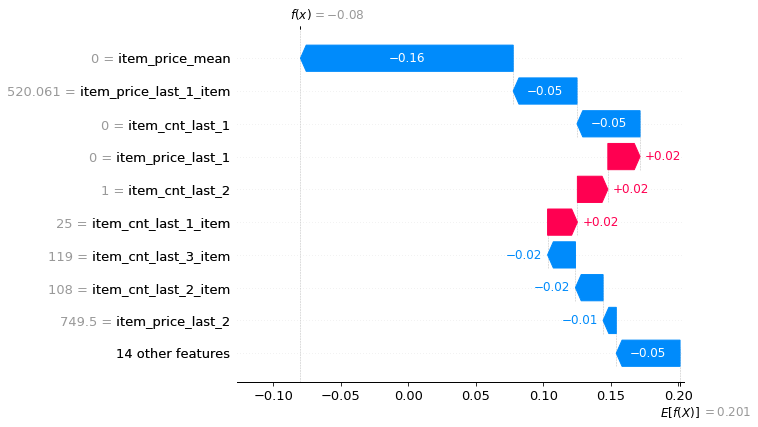

In [19]:
tsc.explain_model(tsc.final_estimator)

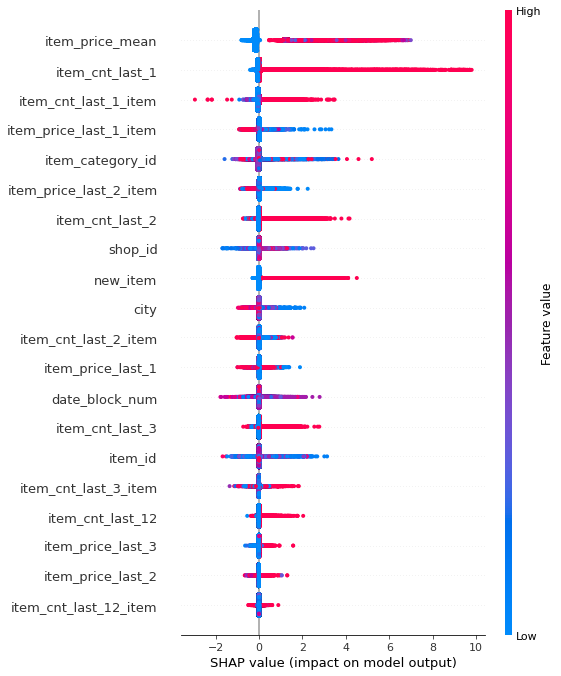

In [19]:
X_sampled = all_data[all_data['date_block_num'] <= 33].sample(1000000, random_state=10).drop(columns=['item_cnt_month'])
tree_explainer = shap.TreeExplainer(tsc.final_estimator)
tree_shap_values = tree_explainer.shap_values(X_sampled)
shap.summary_plot(tree_shap_values, X_sampled)

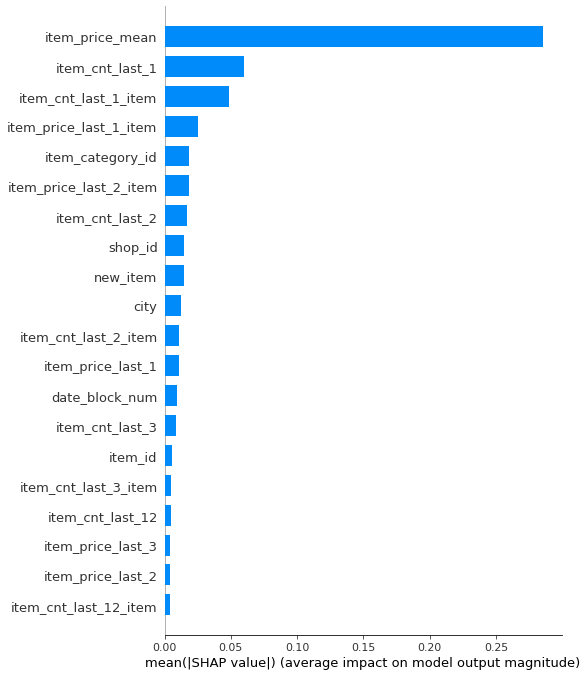

In [20]:
shap.summary_plot(tree_shap_values, X_sampled, plot_type="bar")

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

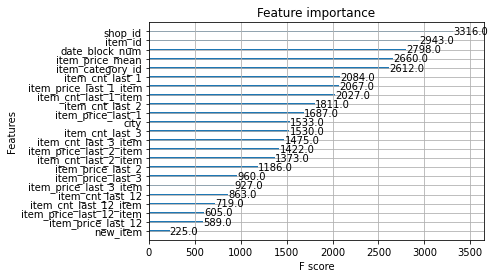

In [23]:
from xgboost import plot_importance
plot_importance(tsc.final_estimator)